#### Capstone Project
# Happiness and Climate

## Introduction

Every year a world happiness report is published. It gathers several statistics on wellbeing and happiness with the help of respondents of over 100 countries. In this project we will collect geojson and venue data of the wordwide happiness and climate data, and discuss how strongly the climate influences the happiness of a country. It is to be expected that there are stronger factors than climate when it comes to overall happiness of the people. However, we will specifically investigate if there is any influence at all.

To answer these questions we plan to do the following:

1) Gather the happiness table

2) Retrieve geojson information of the countries

3) Gather climate data, we will focus on avg. annual temperature and 	precipitation data

4) Merge the tables

5) Visualize the world maps using folium

6) Investigate the correlations between happiness, temperature, and 	precipitation

7) Build a multilinear regression model

8) Analyze the model with scatter plots, histograms, and expected 	variance

We will use unsupervised machine learning techniques and formulate different assumptions leading us through the analysis. Obviously, more specific knowledge could provide a better model - certain factors will always be out of scope. That being said, any considerations are made as realistic as possible.

## Data

The data we use comes from the official world happiness report, compare https://en.wikipedia.org/wiki/World_Happiness_Report . 

It is based on annual samples for the world as a whole, we will use the average data for the years 2016-2018. Three main happiness measures are reported, here we will only consider the first one of them: individual life evaluations. The life evaluation used is the Cantril Ladder, which asks survey respondents to place the status of their lives on a “ladder” scale ranging from 0 to 10, where 0 means the worst possible life and 10 the best possible life.

In the report the effects of country wide factors as health, life expectancy, gdp, and individual factors as income, social support, generosity, and corruption perception, have been considered in detail. Here we will discard those factors and merge the happiness scores with climate scores for the respective countries. More informations about the data can be found on https://s3.amazonaws.com/happiness-report/2019/WHR19_Ch2A_Appendix1.pdf .

Furthermore, we will import tables with typical temperature and precipitation dates for those countries. We will stick to average annual values for each country.

## Methodology, Results, and Discussion
### Header

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV, excel files I/O (e.g. pd.read_csv)
from sklearn import linear_model # machine learning tools
import time                          # To time processes 
import warnings                      # To suppress warnings
import matplotlib.pyplot as plt      # For Graphics
import seaborn as sns
import folium
from sklearn import cluster, mixture # For clustering 
from sklearn.metrics import explained_variance_score

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

### Collecting data and merging dataframes
Let us start by importing the table with the happiness scores

In [2]:
#%conda install xlrd
url = r'https://s3.amazonaws.com/happiness-report/2019/Chapter2OnlineData.xls'
sheet_n = 'Figure2.6'
df_h = pd.read_excel(url, sheet_name = sheet_n)
#discard all but first 2 columns
df_h = df_h.drop(df_h.columns[2:], axis='columns')
df_h = df_h.replace('United States','United States of America')
df_h.head(20)

,Country,Happiness score
0,Finland,7.7689
1,Denmark,7.6001
2,Norway,7.5539
3,Iceland,7.4936
4,Netherlands,7.4876
5,Switzerland,7.4802
6,Sweden,7.3433
7,New Zealand,7.3075
8,Canada,7.2781
9,Austria,7.2460


Now we will import tables with typical temperature and precipitation dates. The world bank provides historic data for the years 1961-1999. Here we will use the respective data and claim that the general climate won't change significantly within 20 years.

In [3]:
url_tp = r'http://databank.worldbank.org/data/download/catalog/cckp_historical_data_0.xls'
sheet_t = 'Country_temperatureCRU'
sheet_p = 'Country_precipitationCRU'
df_t = pd.read_excel(url_tp, sheet_name = sheet_t)
df_t = df_t[['ISO_3DIGIT','Annual_temp']]
df_t.head()

,ISO_3DIGIT,Annual_temp
0,AFG,12.921455
1,AGO,21.510933
2,ALB,11.269800
3,ARE,26.825609
4,ARG,14.215225


Let's do the same for the precipitation data.

In [4]:
df_p = pd.read_excel(url_tp, sheet_name = sheet_p)
df_p = df_p[['ISO_3DIGIT','Annual_precip']]
df_p.head()

,ISO_3DIGIT,Annual_precip
0,AFG,311.321856
1,AGO,991.305683
2,ALB,1053.235184
3,ARE,67.812025
4,ARG,559.045871


Now we have to convert the iso-3digit country labels to English country names, and join all 3 tables.

In [5]:
url_iso = r'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv'
df_3 = pd.read_csv(url_iso)
df_3 = df_3.replace('United Kingdom of Great Britain and Northern Ireland','United Kingdom')
df_3 = df_3.replace('Russian Federation','Russia')
df_3.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [6]:
df_tp = pd.merge( df_t, df_p, on='ISO_3DIGIT', how='inner' )
df_tp.head()

,ISO_3DIGIT,Annual_temp,Annual_precip
0,AFG,12.921455,311.321856
1,AGO,21.510933,991.305683
2,ALB,11.269800,1053.235184
3,ARE,26.825609,67.812025
4,ARG,14.215225,559.045871


In [7]:
df_3 = df_3.rename( {'alpha-3': 'ISO_3DIGIT'}, axis='columns' )
df_tp3 = pd.merge( df_tp, df_3, on='ISO_3DIGIT', how='inner' )
df_tp3 = df_tp3[['name','Annual_temp','Annual_precip','region','sub-region']]
df_tp3 = df_tp3.rename( {'name': 'Country'}, axis='columns' )
df = pd.merge( df_h, df_tp3, on='Country', how='inner')
df['Annual_precip_sqrt'] = np.sqrt(df['Annual_precip'])
df = df[['Country','region','sub-region','Happiness score','Annual_temp',\
         'Annual_precip','Annual_precip_sqrt']]
df.head(2000)

,Country,region,sub-region,Happiness score,Annual_temp,Annual_precip,Annual_precip_sqrt
0,Finland,Europe,Northern Europe,7.7689,1.347861,524.701104,22.906355
1,Denmark,Europe,Northern Europe,7.6001,7.818978,698.649857,26.431985
2,Norway,Europe,Northern Europe,7.5539,0.753892,1051.840741,32.432094
3,Iceland,Europe,Northern Europe,7.4936,1.351409,1039.821209,32.246259
4,Netherlands,Europe,Western Europe,7.4876,9.201738,766.068878,27.677949
5,Switzerland,Europe,Western Europe,7.4802,4.749057,1646.412455,40.576008
6,Sweden,Europe,Northern Europe,7.3433,1.546351,621.150333,24.922888
7,New Zealand,Oceania,Australia and New Zealand,7.3075,9.975832,1790.945674,42.319566
8,Canada,Americas,Northern America,7.2781,-7.144580,457.469053,21.388526
9,Austria,Europe,Western Europe,7.2460,6.186013,1161.183869,34.076148


In [8]:
df.shape

(133, 7)

### Map visualizations
Let's visualize the temperatures on a map using folium.

In [9]:
# download countries geojson file
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
world_geo = r'world_countries.json' # geojson file
world_map_t = folium.Map(location=[20, 20], zoom_start=2, tiles='Mapbox Bright')
# generate choropleth map
world_map_t.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['Country', 'Annual_temp'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Annual Temperature',
)
# display map
world_map_t

Let's now generate the precipitation map.

In [10]:
world_map_p = folium.Map(location=[20, 20], zoom_start=2, tiles='Mapbox Bright')
# generate choropleth map
world_map_p.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['Country', 'Annual_precip_sqrt'],
    key_on='feature.properties.name',
    fill_color='RdBu', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Annual Precipitation (Sqrt)',
)
# display map
world_map_p

Let's generate the happiness map.

In [11]:
world_map_h = folium.Map(location=[20, 20], zoom_start=2, tiles='Mapbox Bright')
# generate choropleth map
world_map_h.choropleth(
    geo_data=world_geo,
    data=df,
    columns=['Country', 'Happiness score'],
    key_on='feature.properties.name',
    fill_color='RdYlGn', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Happiness score',
)
# display map
world_map_h

### Correlation plot
Let us now look at correlations of happiness, temperature, precipitation.

                 Happiness score  Annual_temp  Annual_precip
Happiness score         1.000000    -0.458210       0.028344
Annual_temp            -0.458210     1.000000       0.309285
Annual_precip           0.028344     0.309285       1.000000


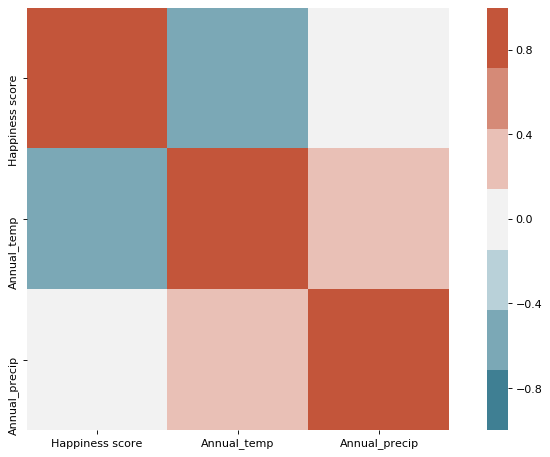

In [12]:
df_stats = df[['Happiness score','Annual_temp','Annual_precip']]
corr = df_stats.corr()
print(corr)
plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corr,
            vmin=-1, vmax=1,
            xticklabels=corr.columns, yticklabels=corr.columns,
            cmap=sns.diverging_palette(220, 20, n=7),
            square=True)
plt.show()

This is interesting! While happiness is negatively correlated with the temperature, with a decent correlation coefficient c of c=-0.46, precipitation and happiness are not correlated (c=0.03), even though there is a slight positive correlation between temperature and precipitation (c=0.31).

### Model building
Let us now build a simple linear regression model to see how well we can predict the happiness in a country, only by knowing its annual temperature and precipitation.

This is expected to work fairly poorly. Here, it is not the intention to build a model that predicts happiness of new countries, and splitting into train / test sets, cross-validation for parameter tuning do not make much sense. The simple 2d multilinear regression model only serves as a simple approach to judge if additional dependent variables are needed to explain the observed response variable happiness.

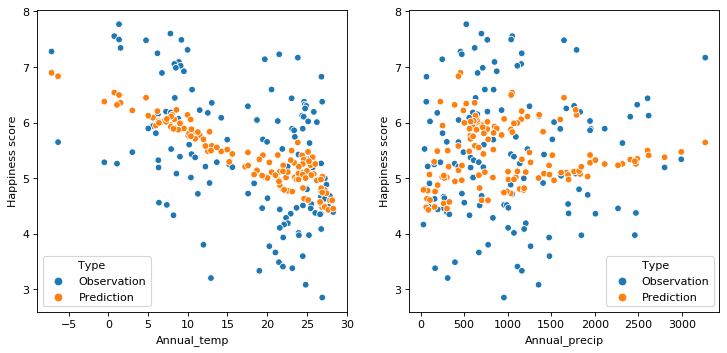

In [13]:
X = df[['Annual_temp','Annual_precip']]
X1 = X['Annual_temp']
X2 = X['Annual_precip']
y = df['Happiness score']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
y_ = model.predict(X)
y1 = y.copy()
y1 = y1.to_frame()
y1 = y1.assign(Type='Observation')
n = len(y1.index)
y2 = y_.copy()
y2 = pd.DataFrame(data=y2,index=range(n,2*n),columns=['Happiness score'])
y2 = y2.assign(Type='Prediction')
Y_ = pd.concat([y1, y2], axis=0)
Y_ = Y_.astype({'Type': 'category'})
X_ = pd.concat([X, X], axis=0)
#X_ = X_.to_frame()
X_ = X_.reset_index(drop=True)
Y_ = pd.concat([Y_, X_], axis=1)
plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
g1 = sns.scatterplot(x="Annual_temp", y="Happiness score", data=Y_, hue="Type")
plt.subplot(1, 2, 2)
g2 = sns.scatterplot(x="Annual_precip", y="Happiness score", data=Y_, hue="Type")
plt.show()

Again, these two plots in a way reproduce the decent negative correlation of temperature and happiness, and also show that the model assumes a small positive impact of the precipitation. It is apparent that very few countries have a very high precipitation or a very low temperature. Either way, the temperature clearly is the major indicator of happiness among the two.

### Histograms and explained variance
How strongly predictive are the two climate factors temperature and precipitation?
Previously we noticed that the model produces a relatively tight band of predictions, i.e. extreme values of happiness are not predicted or are predicted poorly.
Let us take a better look at this fact by plotting the individual histograms of the observations, and the predictions.

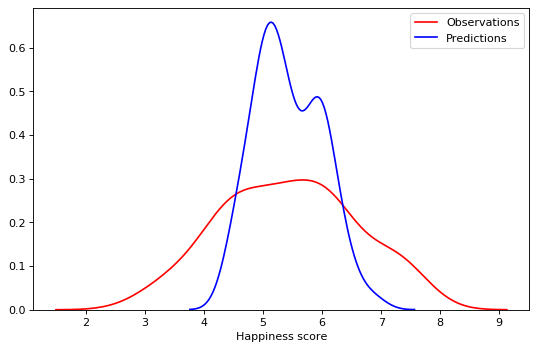

In [14]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
ax1 = sns.distplot(y, hist=False, color="r", label="Observations")
sns.distplot(y_, hist=False, color="b", label="Predictions" , ax=ax1)
plt.show()

Let us now calculate the explained variance of the model.

In [15]:
exp_var = explained_variance_score(y, y_)
print(f"Explained variance: {exp_var}")

Explained variance: 0.24193642911904756


This is clearly not a high value. The considered values in the report as health, life expectancy, gdp, income, etc. allow for much better models.

## Conclusion

In this project we have collected different data sets about happiness, temperature, and precipitation of in total 133 countries. We merged the data and visualized the three variables on a world choropleth map using folium.

We then investigated the correlations. We found that temperature and happiness show a negative correlation of c=-0.46 while precipitation and happiness show no explicit correlation.

We built a linear regression model of the two independent variables temperature and precipitation, and happiness as the dependent variable. We used scatterplots to compare the predictions with the observations. It was apparent that the model was performing poor in general and only reproduced rough trends - extreme values of happiness could not be predicted and many outliers were visible.

We confirmed this assessment by comparing histograms of observations and predictions, and by calculating the explained variance, which resulted in a poor value of exp_var = 0.24.

It is not to be expected that there is a hidden non-linear connection between temperature, precipitation, and happiness. Instead different factors like health, life expectancy, gdp, income, etc. are needed to produce better regression models.

The goal of the project was not to find the best regression model but to understand if temperature and precipitation have an impact at all if it comes to happiness of a country.
The data analysis suggests that there is indeed a negative correlation between happiness and temperature, while the effect of precipitation is negligible.

A possible explanation is the following: in the rich countries water supply is not a problem due to advanced pipe systems while in the poor countries humans settle at places where water supply is a solvable problem most of the time, i.e. close to coast lines, rivers, or seas. The issue of extreme heat on the other hand leads to many heat deaths every year, even in the rich countries. Furthermore, heat strongly impacts people who need to travel to work and when surpassing a certain threshold is anything but comfortable. In Spain and other countries, during summer time it is normal for people to stop working in the early afternoon for 2-3 hours and to take a long nap instead, since other actions are not possible in the heat.

Considering the global warming, humanity might need to come up with new ideas to make living in heat a bit more comfortable and less threatening.